In [220]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose

import pandas as pd
from scipy.signal import find_peaks

# Run on the floor kinematic data

In [221]:
# Initialize simulation
run_time = 1.0
sim_params = MuJoCoParameters(timestep=1e-4, render_mode="saved", render_playspeed=0.1, actuator_kp=20.0)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    
)

In [222]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
    data = pickle.load(f)


# load from fly1
fly1_path = Path("/Users/stimpfli/Desktop/MuJoCo_Neuromechfly/fly1/df3d/joint_angles__210902_PR_Fly1.pkl")
with open(fly1_path, 'rb') as f:
    data_fly1 = pickle.load(f)

data_fly1["meta"] = {"timestep":5e-4}

start = int(3.0/data_fly1["meta"]["timestep"])
end = start + int(run_time/data_fly1["meta"]["timestep"])

In [223]:
start, end

(6000, 8000)

In [224]:
len(data_fly1['LF_leg']["ThC_pitch"])*data_fly1["meta"]["timestep"]

9.986

In [225]:
# Interpolate 5x
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))

joint_nmf_to_flygy_corresp = {"ThC_pitch":"Coxa", "ThC_roll":"Coxa_roll", "ThC_yaw":"Coxa_yaw",
                 "CTr_pitch":"Femur", "CTr_roll":"Femur_roll",
                 "FTi_pitch":"Tibia",
                 "TiTa_pitch":"Tarsus1"}
joint_flygym_to_nmf_corresp = {v:k for k,v in joint_nmf_to_flygy_corresp.items()}


measure_t = np.arange(len(data_fly1['LF_leg']["ThC_pitch"][start:end])) * data_fly1['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    leg = joint[6:8] +"_leg"
    
    data_block[i, :] = np.interp(interp_t, measure_t, data_fly1[leg][joint_flygym_to_nmf_corresp[joint[8:]]][start:end])
    print(np.mean(data_block[i, :]), np.std(data_block[i, :]), np.mean(data[joint]), np.std(data[joint]))

#measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
#interp_t = np.arange(num_steps) * nmf.timestep
#for i, joint in enumerate(nmf.actuated_joints):
#    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

0.3513569373452734 0.284465508562539 0.3514503341050009 0.2844877231025827
0.6160586362544332 0.17515280917166737 0.6161231176640636 0.17520117222336504
-0.14937745098494093 0.07793764385960503 -0.14936636370013445 0.07797583436381372
-2.1309672128219748 0.39207161937783236 -2.1311350054099774 0.39203660577986793
0.18532006854068908 0.17324348897257302 0.1853778175902131 0.17328342657924692
1.43144316164253 0.4262887225718644 1.43158729654919 0.4262768981395847
-0.6651975415337179 0.17628351567277623 -0.6651784207190283 0.1763541561457742
0.08396741179413013 0.04536274135390038 0.08398035387281018 0.045371907101300415
1.837110932954579 0.1505853223298244 1.8370704245099017 0.1506107583176693
0.049819231483677354 0.08007454408491532 0.04982477188727561 0.0800856120836353
-1.9544781187778038 0.16744124226836082 -1.9544684465305644 0.16747165189595542
0.2940648834948227 0.1758451283050039 0.2941342268198981 0.175874261611081
1.865288723297878 0.12083406372054337 1.8652493564516468 0.12084

In [226]:
interp_t.shape, measure_t.shape, len(data_fly1[leg][joint_flygym_to_nmf_corresp[joint[8:]]][start:end])

((10000,), (2000,), 2000)

In [227]:
# Run simulation
obs, info = nmf.reset()

obs_list = [obs]
for i in trange(num_steps):
    joint_pos = data_block[:, i]
    action = {'joints': joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
    obs_list.append(obs)

100%|██████████| 10000/10000 [01:57<00:00, 84.94it/s]


As before, we save and inspect the video:

In [228]:
video_path = Path('kin_replay/video.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

# Extract step data

In [229]:
# Build a contact_dataframe that for each leg and each timestep, has the contact status (force > 0 or not)
legs = ["RF", "RM", "RH", "LF", "LM", "LH"]

contact_data = [np.sum(obs["contact_forces"], axis=0) for obs in obs_list]
contact_sensor_in_leg = [[i for i, name in enumerate(nmf.contact_sensor_placements) if leg in name] for leg in legs]
contact_data = (np.sum(np.array(contact_data)[:, contact_sensor_in_leg], axis=2) > 0).astype(int)
contact_data = pd.DataFrame(contact_data, columns=[leg + "Tarsus5" for leg in legs])
contact_data_filtered = contact_data.copy()
rolling_window = 501
contact_data_filtered = contact_data_filtered.rolling(rolling_window, center=True).quantile(0.35)
contact_data_filtered.head()

,RFTarsus5,RMTarsus5,RHTarsus5,LFTarsus5,LMTarsus5,LHTarsus5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
position_data = [obs["end_effectors"] for obs in obs_list]
end_effector_names = [ee.name[:-4] for ee in nmf.end_effector_sensors]
coordinate = ["x", "y", "z"]
# generate double index
columns = pd.MultiIndex.from_product([end_effector_names, coordinate])
position_data_clean = pd.DataFrame(np.array(position_data).reshape(-1, 18), columns=columns)
position_data_clean.head()

LFTarsus5                     LMTarsus5                     LHTarsus5  \
          x         y         z         x         y         z         x   
0  1.944485  0.140680  1.888506 -0.069129  2.193017  1.495688 -2.236498   
1  1.948557  0.154383  1.877701 -0.069690  2.194469  1.486042 -2.236943   
2  1.954063  0.177125  1.859284 -0.070674  2.195693  1.470541 -2.235670   
3  1.959840  0.205437  1.834852 -0.071624  2.196284  1.450738 -2.232330   
4  1.965166  0.236924  1.805397 -0.072186  2.196121  1.427278 -2.226929   

                      RFTarsus5                     RMTarsus5            \
          y         z         x         y         z         x         y   
0  1.184484  1.484857  1.942043 -0.204991  1.894864 -0.051709 -2.247098   
1  1.188510  1.471612  1.946949 -0.211812  1.888120 -0.051389 -2.248988   
2  1.194527  1.450825  1.954067 -0.222682  1.874193 -0.050885 -2.250667   
3  1.201830  1.424858  1.962417 -0.236045  1.854228 -0.050047 -2.251629   
4  1.210075  1.394534  1.971417 -0.250795  1.829204 -0.048732 -2.251754   

            RHTarsus5                      
          z         x         y         z  
0  1.490431 -2.228579 -1.234326  1.486086  
1  1.481573 -2.228291 -1.239272  1.476212  
2  1.467678 -2.226748 -1.248494  1.456916  
3  1.450351 -2.223807 -1.261037  1.429514  
4  1.430196 -2.219407 -1.276065  1.394912

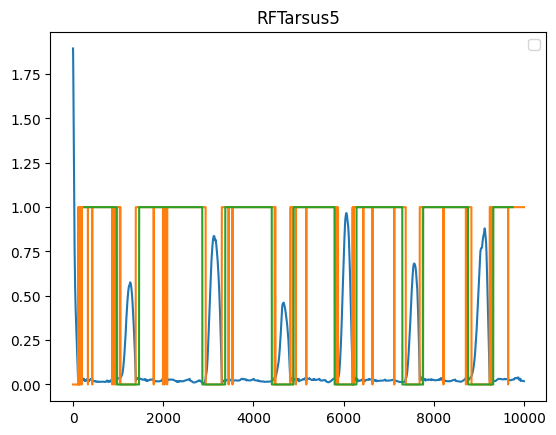

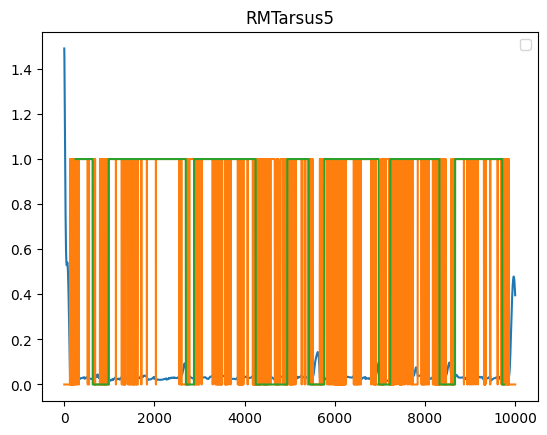

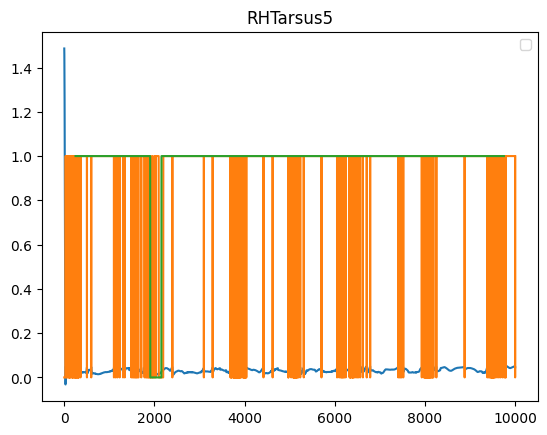

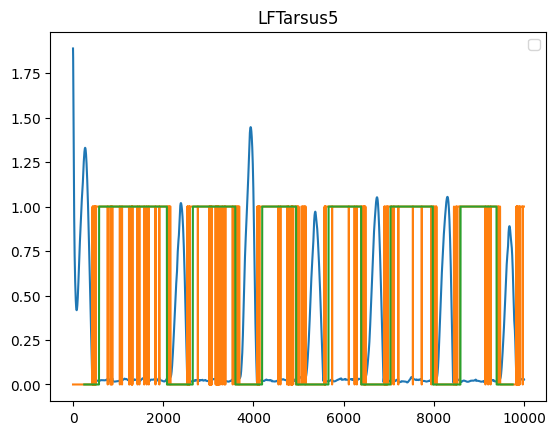

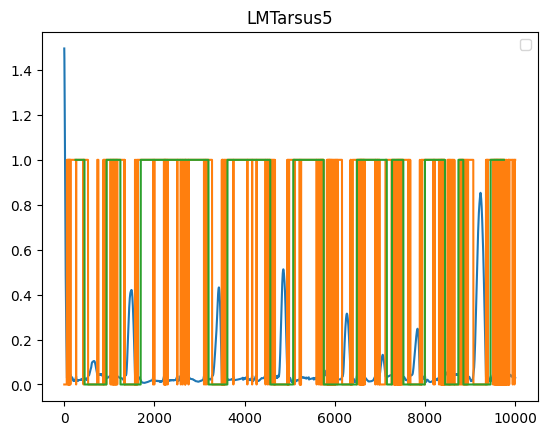

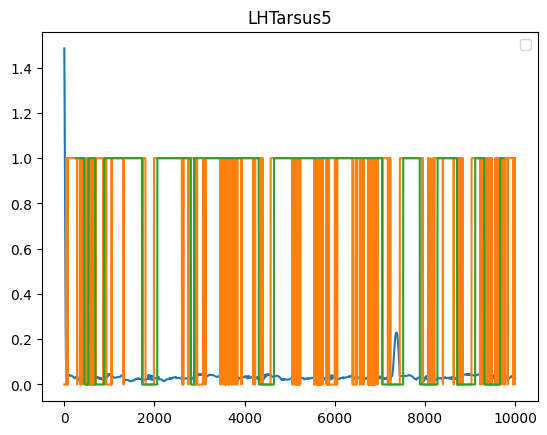

In [231]:
# plot every trace 
for leg in legs:
    keypoint = leg + "Tarsus5"
    plt.plot(position_data_clean[keypoint, "z"])
    plt.plot(contact_data[keypoint])
    plt.plot(contact_data_filtered[keypoint])
    plt.legend()
    plt.title(keypoint)
    plt.show()

[ 269 2392 3939 5372 6741 8304 9679]
0 1348 3600 4948


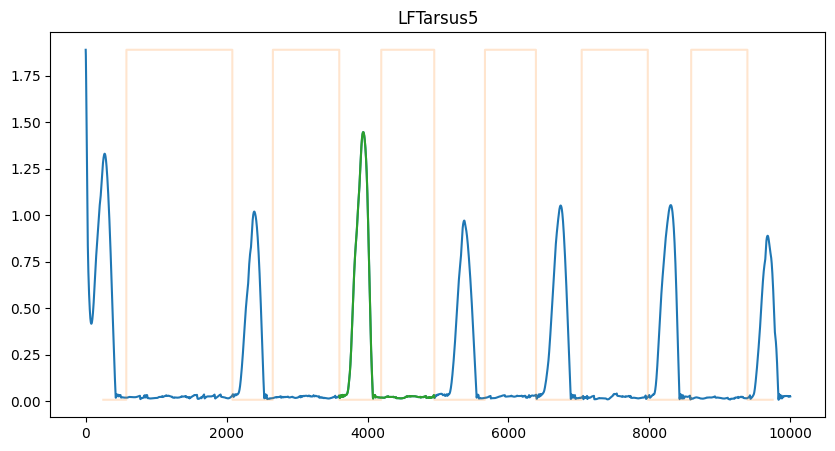

[1268 3126 4671 6061 7568 9129]
0 1503 5800 7303
Kept Left peak


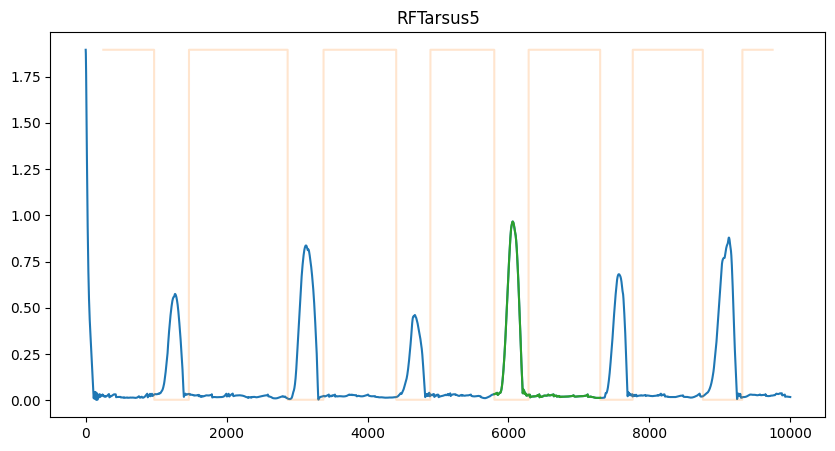

[1491 3429 4858 6268 7835 9231]
0 604 8850 9454
1 1185 4569 5754


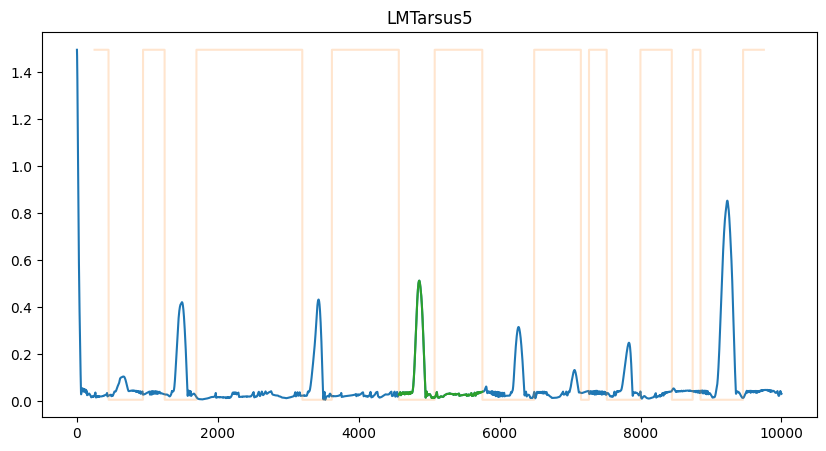

[1594 2666 4205 5622 6975 8542]
0 1549 5426 6975
Kept Left peak


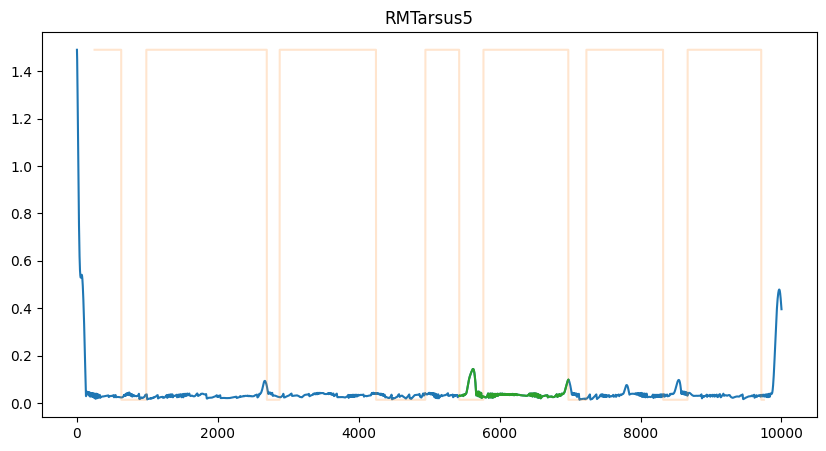

[1316 2970 4506 6015 7366 8843]
0 830 7054 7884
1 1343 2970 4313


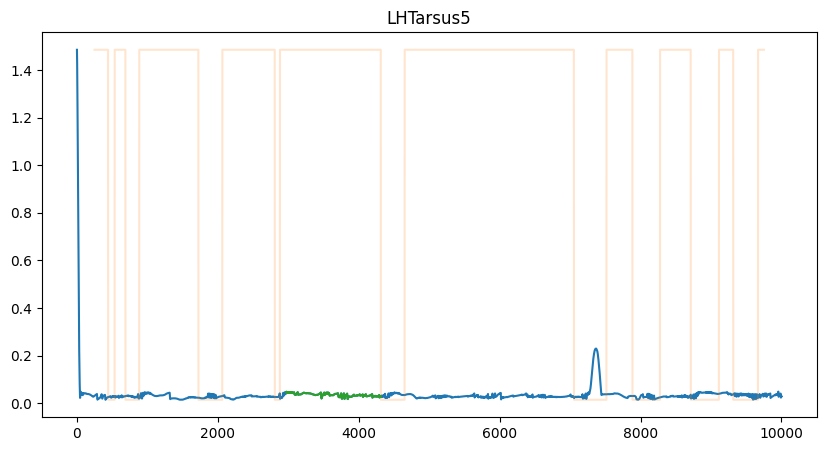

[1873 3833 5099 6623 8070 9496]
0 0 9496 9496
1 0 3833 3833
2 0 8070 8070
No suitable peak found
Kept Left peak


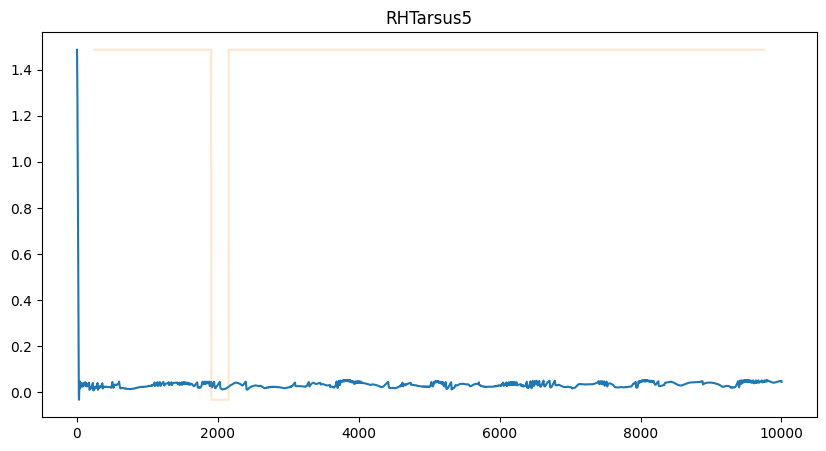

In [232]:
old_start_cycle = 0
old_end_cyle = 0
old_max_val = 0
keypoints_taken = []

all_start_cycles = []
all_end_cycles = []

for location in ["F", "M", "H"]:
    old_start_cycle = 0
    old_end_cyle = 0
    old_max_val = 0
    for side in ["L", "R"]:
        keypoint = f"{side}{location}Tarsus5"
        zpos_data = position_data_clean[keypoint, "z"].values
        contact_data = contact_data_filtered[keypoint].values

        # Get the indices of the peak with highest amplitude subsequent plateau
        # Plateau should be between 1000 and 2000 steps long (measure for 3 peaks with highest amplitude)
        peaks =  find_peaks(zpos_data, distance=1000, prominence=0.01)
        peaks_ids = peaks[0]
        nan_contact_peaks = np.isnan(contact_data[peaks_ids])
        peaks_ids = peaks_ids[~nan_contact_peaks]
        if len(peaks_ids) > 0:
            print(peaks_ids)
            dur = 0
            k = 0
            while (dur < 1000 or dur > 2000) and k < 3:
                # look at the peak from the z position data
                if k > 0:
                    peaks_ids = np.delete(peaks_ids, id_max_peak)
                id_max_peak = np.nanargmax(zpos_data[peaks_ids])
                max_peak_id = peaks_ids[id_max_peak]
                max_val = zpos_data[max_peak_id]

                # Look at the beginning and end of a cycle in the contact data
                start_cycle = max_peak_id - np.nanargmax(contact_data[:max_peak_id][::-1])
                next_stance_start = max_peak_id + np.nanargmax(contact_data[max_peak_id:])
                end_cycle = next_stance_start + np.nanargmax(np.logical_not(contact_data[next_stance_start:]))
                dur = end_cycle - start_cycle
                print(k, dur, start_cycle, end_cycle)
                k += 1     
        else:
            k = 3
            print("No peak found")

        if k > 2:
            max_val_old = 0
            max_val = 0
            print("No suitable peak found")
    
        if side == "R":
            if old_max_val > max_val:
                all_start_cycles.append(old_start_cycle)
                all_end_cycles.append(old_end_cyle)
                keypoints_taken.append(f"L{location}Tarsus5")
                print("Kept Left peak")
            else:
                all_start_cycles.append(start_cycle)
                all_end_cycles.append(end_cycle)
                keypoints_taken.append(keypoint)
                print("Kept Right peak")
        
        old_max_val = max_val
        old_start_cycle = start_cycle
        old_end_cyle = end_cycle

        # Visualize
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        t = np.arange(len(zpos_data))
        ax.plot(t, zpos_data)
        scaling = np.nanmax(zpos_data) - np.nanmin(zpos_data)
        ax.plot(t, contact_data_filtered[keypoint]*scaling + np.nanmin(zpos_data), alpha=0.2)
        if k < 3:
            ax.plot(t[start_cycle:end_cycle], zpos_data[start_cycle:end_cycle])
        ax.set_title(keypoint)
        plt.show()

In [233]:
keypoints_taken

['LFTarsus5', 'LMTarsus5', 'LHTarsus5']

['FCoxa',
 'FCoxa_roll',
 'FCoxa_yaw',
 'FFemur',
 'FFemur_roll',
 'FTibia',
 'FTarsus1',
 'MCoxa',
 'MCoxa_roll',
 'MCoxa_yaw',
 'MFemur',
 'MFemur_roll',
 'MTibia',
 'MTarsus1',
 'HCoxa',
 'HCoxa_roll',
 'HCoxa_yaw',
 'HFemur',
 'HFemur_roll',
 'HTibia',
 'HTarsus1']

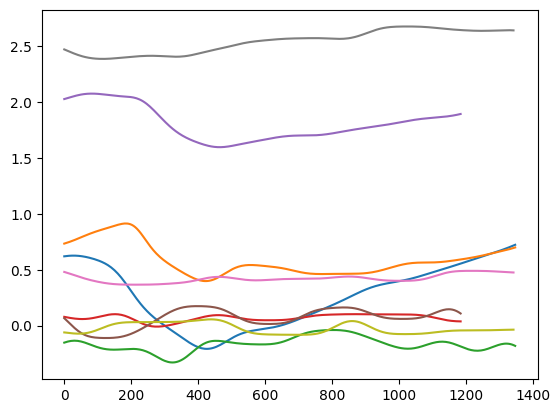

In [234]:
#step_max_len = max()   

step_joint_data = []
stepping_joint = []
stance_or_swing_joint = []

for joint in nmf.actuated_joints:
    for i, kpt in enumerate(keypoints_taken):
        #print(kpt[7:9], joint)
        if kpt[:2] in joint:
            step_joint_data.append(data_block[nmf.actuated_joints.index(joint)][all_start_cycles[i]:all_end_cycles[i]])
            if "Coxa" in joint:
                plt.plot(data_block[nmf.actuated_joints.index(joint)][all_start_cycles[i]:all_end_cycles[i]])
            stepping_joint.append(joint[7:])
        

stepping_joint

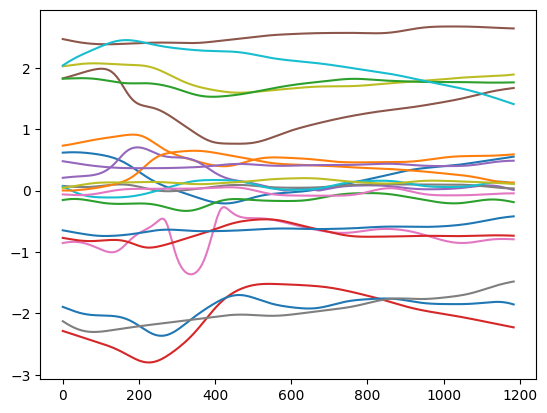

In [235]:
# Traces seem time locked thus only crop all to the shortest
step_min_len = min([end - start for start, end in zip(all_start_cycles, all_end_cycles)])

for i in range(len(step_joint_data)):
    step_joint_data[i] = step_joint_data[i][:step_min_len]

plt.plot(np.transpose(step_joint_data))
plt.show()

Additional timesteps: 11
0.6196104842153712 0.6196104842153712
0.7333859189952144 0.7333859189952144
-0.15274467047212237 -0.15274467047212237
-2.2872361052557104 -2.2872361052557104
0.20939640483942817 0.20939640483942817
1.8294770330507861 1.8294770330507861
-0.8533781460523103 -0.8533781460523103
0.07795145633747902 0.07795145633747902
2.026784424884781 2.026784424884781
0.06588209281997054 0.06588209281997054
-1.8943327115751392 -1.8943327115751392
0.003178335113781377 0.003178335113781377
1.8248204408736863 1.8248204408736863
-0.7701758439420039 -0.7701758439420039
0.47987639952842814 0.47987639952842814
2.4710907548623693 2.4710907548623693
-0.06138754961594363 -0.06138754961594363
-2.1282568731957956 -2.1282568731957956
0.04574521596345 0.04574521596345
2.040422634887175 2.040422634887175
-0.6466224363930404 -0.6466224363930404


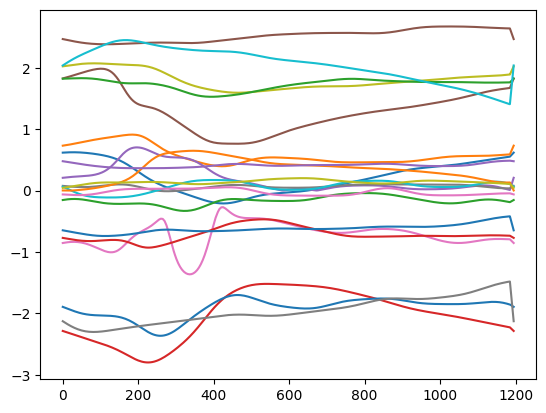

In [236]:
# Interpolate between beginning and end
additional_timesteps_percentage = 0.01
additional_timesteps = int(additional_timesteps_percentage * step_min_len)
print(f"Additional timesteps: {additional_timesteps}")

step_joint_data_interpolated = []
stance_or_swing_joint_interpolated = []

for i in range(len(step_joint_data)):
    step_joint_data_interpolated.append(np.concatenate([step_joint_data[i],
                                         np.linspace(step_joint_data[i][-1], step_joint_data[i][0], additional_timesteps)])
                                         )
    print(step_joint_data_interpolated[i][0], step_joint_data_interpolated[i][-1])

plt.plot(np.transpose(step_joint_data_interpolated))
plt.show()

In [237]:
kin_replay_leg_dofs = [
    f'joint_{side}{pos}{dof}'
    for side in 'LR'
    for pos in 'FMH'
    for dof in ['Coxa', 'Coxa_roll', 'Coxa_yaw',
                'Femur', 'Femur_roll',
                'Tibia',
                'Tarsus1']
]

all_joints_single_step_data = {"meta":{"timestep":0.0001,
                                       "source":"Analyze_step_data.ipynb"}
}

sides_taken = [key[7:9] for key in keypoints_taken]
for i, joint in enumerate(nmf.actuated_joints):
    reference_data = step_joint_data_interpolated[stepping_joint.index(joint[7:])]
    """if not joint[6:8] in sides_taken and ("roll" in joint or "yaw" in joint):
        print(joint)
        #reference_data = -1*reference_data"""

    if np.sign(reference_data[0]) == np.sign(np.mean(data_block[i])):
        all_joints_single_step_data[joint] = reference_data   
    else:
        print(joint)
        all_joints_single_step_data[joint] = -1*reference_data
    #all_joints_single_step_data[joint] = reference_data

joint_RFCoxa_roll
joint_RFCoxa_yaw
joint_RFFemur_roll
joint_RMCoxa_roll
joint_RMFemur_roll
joint_RHCoxa_roll


# Run CPG

In [238]:
from flygym.util.turning_controller import TurningController
from flygym.util.cpg_controller import plot_phase_amp_output_rules, sine_output


In [239]:
# Initialize the simulation
enable_adhesion = True
run_time = 1.5
sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_left_top_zoomout",
    render_playspeed=0.1,
    actuator_kp=30,
    enable_adhesion=True,
    draw_adhesion=True,
    #adhesion_gain=20,
)
nmf = TurningController(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    spawn_pos = [0, 0, 0.5],
    stabilisation_dur = 0.3
)

num_steps_base = int(run_time / nmf.timestep)

In [240]:
# Note that adhesion will not be perfect as stance phase was not defined with this kinematic data

In [241]:
#override joint angles with the ones derived in this script
step_duration = len(all_joints_single_step_data["joint_LFCoxa"])
nmf.interp_step_duration = int(
    step_duration * all_joints_single_step_data["meta"]["timestep"] / nmf.timestep
)
new_step_data = np.zeros((len(nmf.actuated_joints), nmf.interp_step_duration))

for i, joint in enumerate(nmf.actuated_joints):
    new_step_data[i, :] = all_joints_single_step_data[joint]

nmf.step_data = new_step_data

In [242]:
np.random.seed(42)
    
obs, info = nmf.reset()
phases, amplitudes, obs_list = nmf.run_stabilisation()
action = [1.0, 1.0]
for i in trange(num_steps):
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list.append(obs)
    render_status = nmf.render()
    phases.append(nmf.cpg.phase)
    amplitudes.append(nmf.cpg.amplitude)

100%|██████████| 10000/10000 [00:29<00:00, 337.22it/s]


In [243]:
video_path = Path(f"CPG_single_step.mp4")
if nmf.sim_params.render_mode == "saved":
    nmf.save_video(video_path, 0)

In [244]:
from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

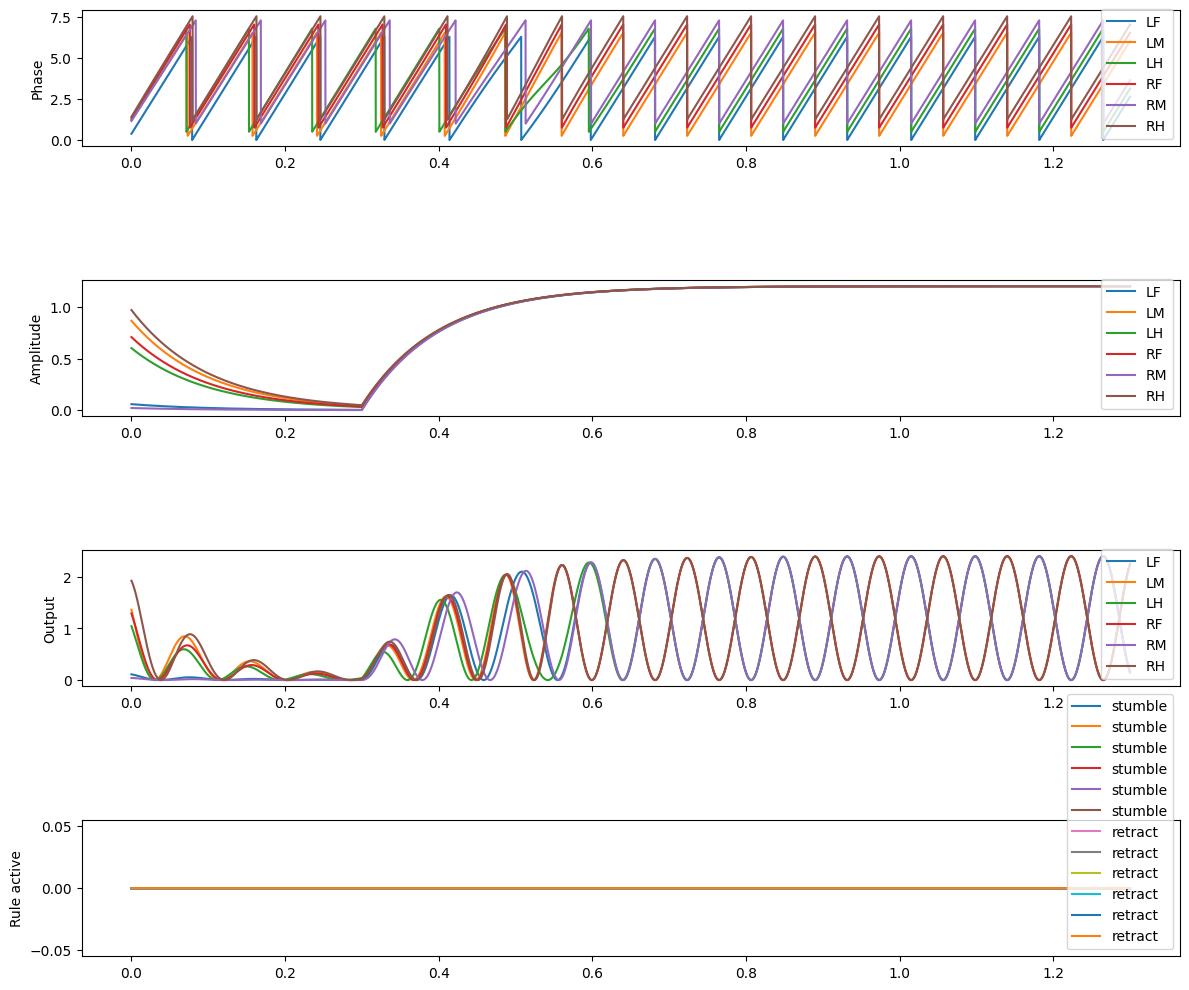

In [245]:
stumble_active = retract_active = np.zeros_like(phases)
legs = ["LF", "LM", "LH", "RF", "RM", "RH"]
plot_phase_amp_output_rules(
    phases + np.arange(len(legs))*0.25,
    amplitudes,
    sine_output(phases, amplitudes),
    [stumble_active, retract_active],
    labels=legs,
    rule_labels=["stumble","retract"],
    timestep=nmf.timestep
)
plt.show()